In [1]:
import dill
import pandas as pd
import datetime
import time
import pickle
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector

In [3]:
df = pd.read_csv('data/ga_sessions.csv', low_memory=False)
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [4]:
df.shape

(1860042, 18)

In [7]:
df2 = pd.read_csv('data/ga_hits.csv', low_memory=False)
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [8]:
df2.shape

(15726470, 11)

In [9]:
values_to_select = [
    'sub_car_claim_click', 
    'sub_car_claim_submit_click',
    'sub_open_dialog_click', 
    'sub_custom_question_submit_click',
    'sub_call_number_click', 
    'sub_callback_submit_click', 
    'sub_submit_success',
    'sub_car_request_submit_click'
]

selected_rows = df2[df2['event_action'].isin(values_to_select)][['session_id', 'event_action']]
selected_rows['event_action'] = 1
selected_rows.head()

,session_id,event_action
4016,2744563715298057088.1640258436.1640258436,1
4045,3087297479839089634.1640268774.1640268774,1
4046,3156966333326004302.1640206419.1640206800,1
4047,3750243879753098158.1640272208.1640272208,1
4048,7518333712042258254.1640258901.1640258901,1


In [10]:
selected_rows[selected_rows.duplicated()].shape

(54148, 2)

In [11]:
selected_rows = selected_rows.drop_duplicates()
df = df.merge(selected_rows, on='session_id', how='left')
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,event_action
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,NaN
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,NaN
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,NaN
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,NaN
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,NaN


In [12]:
df['event_action'] = df['event_action'].apply(lambda x: 0 if pd.isnull(x) else x)
df['event_action'] = df['event_action'].astype(int)

In [13]:
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,event_action
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0


## Data Preparation

### Data Cleaning

#### Duplicates

In [14]:
df[df.duplicated()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,event_action


#### Missing values

In [15]:
df.describe(include='all')

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,event_action
count,1860042,1860042,1860042,1860042,1.860042e+06,1859945,1860042,1640439,1524427,777981,1860042,789904,1492864,16338,1860042,1860042,1860042,1860042,1.860042e+06
unique,1860042,1391719,226,85318,NaN,293,56,412,286,1219,3,13,205,104,5039,57,166,2548,NaN
top,9055434745589932991.1637753792.1637753792,1750498477.1629450062,2021-05-24,12:00:00,NaN,ZpYIoDJMcFzVoPFsHGJL,banner,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Apple,AuMdmADEIoPXiWpTsBEj,414x896,Chrome,Russia,Moscow,NaN
freq,1,462,39453,61067,NaN,578290,552272,463481,1006599,506819,1474871,464054,551088,9778,169090,1013436,1800565,805329,NaN
mean,NaN,NaN,NaN,NaN,2.712804e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.704993e-02
std,NaN,NaN,NaN,NaN,1.182907e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.622290e-01
min,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
50%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
75%,NaN,NaN,NaN,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00


In [ ]:
for i in df.columns:
    print('Характеристика', i)
    print('Количество уникальных значений', df[i].nunique())
    print('Список значений: ')
    print(df[i].value_counts())

In [16]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1860042 entries, 0 to 1860041
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   session_id                1860042 non-null  object
 1   client_id                 1860042 non-null  object
 2   visit_date                1860042 non-null  object
 3   visit_time                1860042 non-null  object
 4   visit_number              1860042 non-null  int64 
 5   utm_source                1859945 non-null  object
 6   utm_medium                1860042 non-null  object
 7   utm_campaign              1640439 non-null  object
 8   utm_adcontent             1524427 non-null  object
 9   utm_keyword               777981 non-null   object
 10  device_category           1860042 non-null  object
 11  device_os                 789904 non-null   object
 12  device_brand              1492864 non-null  object
 13  device_model              16338 non-null  

In [17]:
df.isna().sum().sort_values()

session_id                        0
geo_country                       0
device_browser                    0
device_screen_resolution          0
device_category                   0
geo_city                          0
event_action                      0
visit_number                      0
visit_time                        0
visit_date                        0
client_id                         0
utm_medium                        0
utm_source                       97
utm_campaign                 219603
utm_adcontent                335615
device_brand                 367178
device_os                   1070138
utm_keyword                 1082061
device_model                1843704
dtype: int64

In [18]:
missing_values = ((df.isna().sum() / len(df))*100).sort_values()
print("Процент пропущенных значений: ")
missing_values

Процент пропущенных значений: 


session_id                   0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
device_category              0.000000
geo_city                     0.000000
event_action                 0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
client_id                    0.000000
utm_medium                   0.000000
utm_source                   0.005215
utm_campaign                11.806346
utm_adcontent               18.043410
device_brand                19.740307
device_os                   57.533002
utm_keyword                 58.174009
device_model                99.121633
dtype: float64

In [19]:
def print_useful_rows_indo(df):
    print('Количество полностью заполненных объектов из всей выборки:', len(df.dropna()))
    print('Процент полностью заполненных объектов из всей выборки:', round(len(df.dropna()) / len(df) * 100, 2))

In [20]:
df_clean = df.copy()

In [21]:
print_useful_rows_indo(df_clean)

Количество полностью заполненных объектов из всей выборки: 14940
Процент полностью заполненных объектов из всей выборки: 0.8


In [22]:
df_clean.device_model.value_counts(dropna=False)

NaN                     1843704
AuMdmADEIoPXiWpTsBEj       9778
tWBQlsvNfHxRUjaPAfhd        653
cwMJxNXiWUgMUxGiCTPs        651
pTgAEPipQxDXCjPrJbHo        461
                         ...   
LDCqZZOpaddysclyNkHj          1
MBGYWAQSYWUphNxTsAWD          1
VDidzTqFGxuqiRQJGrwB          1
aWSBcBZlKorTFjJGlWKG          1
niQdLVcBlNylrEuNcCYH          1
Name: device_model, Length: 105, dtype: int64

In [23]:
df_clean.device_os.value_counts(dropna=False)

NaN              1070138
Android           464054
iOS               207104
Windows            88307
Macintosh          24824
Linux               5120
(not set)            364
Chrome OS             83
BlackBerry            27
Tizen                  7
Samsung                4
Windows Phone          4
Firefox OS             3
Nokia                  3
Name: device_os, dtype: int64

In [24]:
df_clean.utm_keyword.value_counts(dropna=False)

NaN                     1082061
puhZPIYqKXeFPaUviSjo     506819
aXQzDWsJuGXeBXexNHjc      24241
pHqgLcdBQPSLcrTpLkdr      13767
ITfrGJNwVsHBGJMAKoct      13353
                         ...   
XsuVVTgiDIxZtndPjvDm          1
WhaUakldaAmpLumfaADO          1
nJVPLgfxsBtPAXttNVDI          1
nwKBdMZKktIQFvhZwbFe          1
fcXWTQaKfxbkBkBnzLhK          1
Name: utm_keyword, Length: 1220, dtype: int64

In [25]:
df_clean = df_clean.drop(columns = ['device_model', 'utm_keyword'])

In [26]:
df_clean.isna().sum().sort_values()

session_id                        0
geo_country                       0
device_browser                    0
device_screen_resolution          0
device_category                   0
geo_city                          0
event_action                      0
visit_number                      0
visit_time                        0
visit_date                        0
client_id                         0
utm_medium                        0
utm_source                       97
utm_campaign                 219603
utm_adcontent                335615
device_brand                 367178
device_os                   1070138
dtype: int64

In [27]:
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].str.lower()

##### device_brand

In [28]:
df_clean.device_brand.value_counts(dropna=False)

apple       551088
NaN         367178
samsung     332194
xiaomi      288367
huawei      185853
             ...  
vodafone         1
wexler           1
kingsing         1
star             1
opera            1
Name: device_brand, Length: 206, dtype: int64

In [29]:
df_clean.device_browser.value_counts(dropna=False)

chrome                              1013436
safari                               478562
yabrowser                            133311
safari (in-app)                       69912
android webview                       55369
samsung internet                      47309
opera                                 26817
firefox                               16588
edge                                  16065
uc browser                              871
android runtime                         392
mozilla compatible agent                362
[fban                                   269
instagram 208.0.0.32.135 android        140
instagram 209.0.0.21.119 android        111
mrchrome                                 77
android browser                          49
opera mini                               45
puffin                                   45
internet explorer                        36
maxthon                                  31
android                                  22
instagram 216.1.0.21.137 android

In [30]:
df_clean[df_clean.device_brand.isna()].device_browser.value_counts(dropna=False)

chrome                              215719
yabrowser                            60374
safari                               40955
opera                                18024
edge                                 16063
firefox                              14582
mozilla compatible agent               362
samsung internet                       323
[fban                                  268
instagram 208.0.0.32.135 android       140
instagram 209.0.0.21.119 android       111
mrchrome                                77
internet explorer                       26
android                                 22
instagram 216.1.0.21.137 android        19
maxthon                                 18
(not set)                               17
instagram 194.0.0.36.172 android        15
instagram 202.0.0.37.123 android        12
puffin                                   8
helloworld                               6
mozilla                                  6
instagram 212.0.0.38.119 android         6
instagram 2

In [ ]:
for i in df_clean[df_clean.device_brand.isna()].device_browser.unique():
    print('Browser -', i)
    print(df_clean[df_clean['device_browser'] == i].device_brand.value_counts(dropna=False))

In [32]:
df[(df['device_brand'].isna()) & (df['device_browser'] == 'Safari')].device_screen_resolution.value_counts()

1440x900     13890
768x1024      4344
810x1080      2728
1792x1120     2517
1680x1050     2436
             ...  
1920x1053        1
1920x1057        1
1366x1142        1
360x800          1
360x640          1
Name: device_screen_resolution, Length: 82, dtype: int64

In [33]:
sorted(df[(df['device_brand'].isna()) & (df['device_browser'] == 'Safari')].device_screen_resolution.unique().tolist())

['1024x1280',
 '1024x1366',
 '1024x640',
 '1024x768',
 '1080x1920',
 '1152x648',
 '1152x720',
 '1194x834',
 '1280x1024',
 '1280x720',
 '1280x800',
 '1280x960',
 '1344x840',
 '1352x878',
 '1360x768',
 '1366x1024',
 '1366x1142',
 '1366x768',
 '1440x2560',
 '1440x900',
 '1496x967',
 '1512x982',
 '1536x960',
 '1600x1000',
 '1600x1200',
 '1600x900',
 '1680x1050',
 '1680x918',
 '1680x945',
 '1720x1440',
 '1728x1117',
 '1792x1120',
 '1800x1169',
 '1919x1337',
 '1920x1053',
 '1920x1054',
 '1920x1057',
 '1920x1080',
 '1920x1200',
 '1920x800',
 '2000x2000',
 '2048x1080',
 '2048x1152',
 '2048x1280',
 '2056x1329',
 '2240x1260',
 '2294x1490',
 '2304x1296',
 '2560x1067',
 '2560x1080',
 '2560x1440',
 '2560x1600',
 '2560x1707',
 '2880x1620',
 '3008x1692',
 '3200x1350',
 '3200x1800',
 '320x568',
 '320x693',
 '3360x1440',
 '3360x1890',
 '3440x1440',
 '360x640',
 '360x800',
 '375x667',
 '375x812',
 '3840x1080',
 '3840x1600',
 '3840x2160',
 '390x844',
 '414x736',
 '414x896',
 '428x926',
 '491x1064',
 '512

In [34]:
def set_device_brand(x):
    if pd.notnull(x['device_brand']):
        return x['device_brand']
    elif x['device_browser'] == 'samsung internet':
        return 'samsung'
    elif x['device_browser'] == 'safari':
        return 'apple'
    elif (x['device_category'] == 'desktop') or (int(x['device_screen_resolution'].split('x')[0]) > int(x['device_screen_resolution'].split('x')[1])):
        return 'pc'
    else:
        return '(not set)'

df_clean['device_brand'] = df_clean.apply(set_device_brand, axis=1)

df_clean[df_clean.device_brand.isna()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action


In [35]:
df_clean[df_clean.device_brand.isna()].device_browser.value_counts(dropna=False)

Series([], Name: device_browser, dtype: int64)

##### device_os

In [36]:
df_clean.device_os.value_counts(dropna=False)

NaN              1070138
android           464054
ios               207104
windows            88307
macintosh          24824
linux               5120
(not set)            364
chrome os             83
blackberry            27
tizen                  7
samsung                4
windows phone          4
firefox os             3
nokia                  3
Name: device_os, dtype: int64

In [37]:
brand = dict(df_clean.device_brand.value_counts())
brand

{'apple': 592043,
 'samsung': 332517,
 'pc': 325736,
 'xiaomi': 288367,
 'huawei': 185853,
 'realme': 19058,
 '(not set)': 17709,
 'oppo': 13504,
 'vivo': 11740,
 'oneplus': 9965,
 'asus': 7929,
 'nokia': 7285,
 'sony': 6459,
 'zte': 6365,
 'google': 5150,
 'meizu': 3750,
 'lenovo': 3148,
 'blackview': 2759,
 'tecno': 2654,
 'lg': 2447,
 'motorola': 2357,
 'bq': 1573,
 'itel': 1082,
 'alcatel': 968,
 'doogee': 876,
 'oukitel': 826,
 'htc': 790,
 'umidigi': 661,
 'ulefone': 511,
 'infinix': 417,
 'vsmart': 368,
 'leeco': 344,
 'blackberry': 338,
 'cubot': 320,
 'philips': 299,
 'mozilla': 295,
 'poco': 229,
 'sharp': 226,
 'vertex': 198,
 'tp-link': 194,
 'dexp': 190,
 'prestigio': 171,
 'leagoo': 161,
 'micromax': 143,
 'wileyfox': 137,
 'neffos': 135,
 'inoi': 112,
 'hisense': 103,
 'tcl': 91,
 'homtom': 81,
 'cat': 76,
 'karbonn': 72,
 'highscreen': 64,
 'letv': 64,
 'acer': 53,
 'coolpad': 49,
 'agm': 49,
 'haier': 43,
 'fly': 37,
 'black fox': 36,
 'mito': 34,
 'chuwi': 34,
 'verne

In [38]:
def clean_device_os(data):
    brand = data['device_brand']
    if pd.isna(data['device_os']):
        if isinstance(brand, str):
            if 'apple' in brand:
                return 'ios'
            elif 'pc' in brand:
                return 'windows'
        return 'android'
    return data['device_os']

df_clean['device_os'] = df_clean.apply(clean_device_os, axis=1)

df_clean.device_os.value_counts(dropna=False)

android          942042
ios              578538
windows          309023
macintosh         24824
linux              5120
(not set)           364
chrome os            83
blackberry           27
tizen                 7
samsung               4
windows phone         4
firefox os            3
nokia                 3
Name: device_os, dtype: int64

In [39]:
df_clean[df_clean['device_category']=='desktop'].device_os.value_counts()

windows      308924
ios           27394
macintosh     24804
linux          5063
(not set)       344
android         249
chrome os        83
tizen             2
Name: device_os, dtype: int64

##### utm_adcontent & utm_campaign & utm_source

In [40]:
df_clean.isna().sum().sort_values()

session_id                       0
geo_country                      0
device_browser                   0
device_screen_resolution         0
device_brand                     0
device_os                        0
device_category                  0
geo_city                         0
event_action                     0
utm_medium                       0
visit_number                     0
visit_time                       0
visit_date                       0
client_id                        0
utm_source                      97
utm_campaign                219603
utm_adcontent               335615
dtype: int64

In [41]:
df_clean.utm_campaign.describe()

count                  1640439
unique                     412
top       ltuzkdkfxrgvceowkvyg
freq                    463481
Name: utm_campaign, dtype: object

In [42]:
df_clean.utm_campaign.value_counts(dropna=False)

ltuzkdkfxrgvceowkvyg    463481
leophuyfvzonfnzggfcd    324044
ftjnldytrxawygzymfkv    247360
NaN                     219603
gecbyckzcpmcvydsszkp    134042
                         ...  
rkpoyeepgcmbsduhlqcj         1
pcvpxfvfaamhwfmvieyd         1
qpdtdivqveflljtyijng         1
mhdhrbkqwbdaralwnljq         1
cxxuwxpoqcvaxphpfczl         1
Name: utm_campaign, Length: 413, dtype: int64

In [43]:
df_clean.utm_adcontent.describe()

count                  1524427
unique                     286
top       jnhcplzpxemwdnriyobf
freq                   1006599
Name: utm_adcontent, dtype: object

In [44]:
df_clean.utm_adcontent.value_counts(dropna=False)

jnhcplzpxemwdnriyobf    1006599
NaN                      335615
vcipmpagbniqhyynkxqp     181048
xhoenqgdqsgfepynpwko     113072
pkybgvwbaqormxjnunqz      60316
                         ...   
vxarztovddvnhaliqtvl          1
ryswqhdlvbezpdljokyf          1
gqenaeqmohishsteyzhp          1
planrlymnpceyvurutvj          1
ojivrdnirrockrbikotg          1
Name: utm_adcontent, Length: 287, dtype: int64

In [45]:
df_clean.utm_source.describe()

count                  1859945
unique                     293
top       zpyiodjmcfzvopfshgjl
freq                    578290
Name: utm_source, dtype: object

In [46]:
df_clean.utm_source.value_counts(dropna=False)

zpyiodjmcfzvopfshgjl    578290
fdllacsmythwscvmvqvl    300575
kjslglqlzykirbcdigcd    266354
mvfhsxitijurizxsqzqt    186199
bhcvlfoacwvwtykyqhve    116320
                         ...  
gykgjdhsxirufphfiyse         1
wrhphorkhkxaenrclbfo         1
tjkugsegmhklezdcqbrx         1
wpmatvduimutnvmnvpjo         1
bellrslnbzqzaixvfgxj         1
Name: utm_source, Length: 294, dtype: int64

In [48]:
df_clean[(df_clean.utm_adcontent.isna()) & (df_clean.utm_campaign.isna())]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjslglqlzykirbcdigcd,cpc,NaN,NaN,mobile,android,xiaomi,393x786,chrome,russia,moscow,0
14,9055469620715506713.1636559415.1636559415,2108390820.1628883993,2021-11-10,18:50:15,4,szzerolmmreuehdaycyn,cpc,NaN,NaN,mobile,android,samsung,412x869,android webview,russia,saint petersburg,0
27,9055504865227535872.1639282176.1639282176,2108399026.1639282176,2021-12-12,07:09:36,1,bhcvlfoacwvwtykyqhve,cpc,NaN,NaN,mobile,android,samsung,385x854,chrome,russia,moscow,0
38,905553874150070422.1639028922.1639028922,210840691.1639028886,2021-12-09,08:48:42,2,kjslglqlzykirbcdigcd,cpc,NaN,NaN,mobile,ios,apple,375x812,safari,russia,moscow,0
41,905553874150070422.1639045289.1639045289,210840691.1639028886,2021-12-09,13:21:29,6,kjslglqlzykirbcdigcd,cpc,NaN,NaN,mobile,ios,apple,375x812,safari,russia,moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859982,9055195915335919645.1630169119.1630169119,2108327093.1630169117,2021-08-28,19:00:00,1,bhcvlfoacwvwtykyqhve,cpc,NaN,NaN,mobile,android,xiaomi,393x873,yabrowser,russia,moscow,0
1859987,9055216346490282940.1625105400.1625105400,2108331850.1625105340,2021-07-01,05:00:00,2,kjslglqlzykirbcdigcd,cpc,NaN,NaN,desktop,windows,pc,1920x1080,chrome,russia,moscow,0
1860018,9055329372850890545.1626351420.1626351420,2108358166.1626351409,2021-07-15,15:00:00,1,bhcvlfoacwvwtykyqhve,cpc,NaN,NaN,desktop,windows,pc,1920x1080,yabrowser,russia,moscow,0
1860020,9055329372850890545.1629287172.1629287172,2108358166.1626351409,2021-08-18,14:00:00,3,bhcvlfoacwvwtykyqhve,cpc,NaN,NaN,desktop,windows,pc,1920x1080,yabrowser,russia,moscow,0


In [49]:
df_clean[(df_clean.utm_adcontent.isna()) & (df_clean.utm_campaign.isna())].event_action.value_counts()

0    195860
1      6614
Name: event_action, dtype: int64

In [50]:
df_clean[(df_clean.utm_adcontent.isna()) & (df_clean.utm_campaign.isna()) & (df_clean['event_action']==1)]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action
78,9055794766915104430.1624305327.1624305327,2108466524.1624305326,2021-06-21,22:00:00,1,bhcvlfoacwvwtykyqhve,cpc,NaN,NaN,desktop,ios,apple,834x1112,safari,russia,domodedovo,1
515,9057690488171061142.1625218970.1625218970,2108907906.1625218966,2021-07-02,12:00:00,2,kjslglqlzykirbcdigcd,cpc,NaN,NaN,desktop,ios,apple,1440x900,safari,russia,saint petersburg,1
1825,9063830058034432517.1638345532.1638345532,2110337386.1638304261,2021-12-01,10:58:52,3,kjslglqlzykirbcdigcd,cpc,NaN,NaN,mobile,ios,apple,375x812,safari,russia,zhukovskiy,1
1826,9063830058034432517.1638348218.1638348218,2110337386.1638304261,2021-12-01,11:43:38,4,kjslglqlzykirbcdigcd,cpc,NaN,NaN,mobile,ios,apple,375x812,safari,russia,zhukovskiy,1
1930,9064215243576541223.1628422374.1628422374,2110427069.1628405799,2021-08-08,14:00:00,3,bhcvlfoacwvwtykyqhve,cpc,NaN,NaN,mobile,ios,apple,414x896,safari,russia,vladivostok,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859678,9054030905456243047.1630582733.1630582733,2108055843.1629532519,2021-09-02,14:00:00,11,kjslglqlzykirbcdigcd,cpc,NaN,NaN,mobile,android,xiaomi,360x800,chrome,russia,saint petersburg,1
1859708,9054144322650551699.1623827744.1623827744,2108082250.1622455699,2021-06-16,10:00:00,5,bhcvlfoacwvwtykyqhve,cpc,NaN,NaN,mobile,android,huawei,360x780,yabrowser,russia,moscow,1
1859712,9054144322650551699.1623828501.1623828501,2108082250.1622455699,2021-06-16,10:00:00,9,bhcvlfoacwvwtykyqhve,cpc,NaN,NaN,mobile,android,huawei,360x780,yabrowser,russia,moscow,1
1859718,9054144322650551699.1623992130.1623992130,2108082250.1622455699,2021-06-18,07:00:00,15,bhcvlfoacwvwtykyqhve,cpc,NaN,NaN,mobile,android,huawei,360x780,yabrowser,russia,moscow,1


In [ ]:
for i in df_clean[df_clean.utm_adcontent.isna()].utm_campaign.unique():
    print('utm_campaign -', i)
    print(df_clean[df_clean['utm_campaign'] == i].utm_adcontent.value_counts(dropna=False).head(3))

In [ ]:
for i in df_clean.utm_source.unique():
    print('utm_source -', i)
    print(df_clean[df_clean['utm_source'] == i].utm_adcontent.value_counts(dropna=False).head(3))

In [53]:
df_clean[(df_clean['utm_source']=='kjsLglQLzykiRbcDiGcD') & (df_clean.utm_adcontent.isna())]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action


In [54]:
df_clean[df_clean.utm_source.isna()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action
77652,1100240274910044288.1640728207.1640728207,256169651.1637310592,2021-12-29,00:50:07,2,NaN,(not set),ltuzkdkfxrgvceowkvyg,jnhcplzpxemwdnriyobf,mobile,android,oneplus,412x892,chrome,russia,saint petersburg,0
122841,1303431342277938317.1637250145.1637250145,303478758.1637239949,2021-11-18,18:42:25,3,NaN,sbol_catalog,cccmlyvfjxspfacsrmso,jnhcplzpxemwdnriyobf,mobile,ios,apple,375x667,safari,russia,balashikha,0
136220,1364914954463538089.1637595059.1637595059,317794027.1634397097,2021-11-22,18:30:59,8,NaN,(not set),ltuzkdkfxrgvceowkvyg,jnhcplzpxemwdnriyobf,mobile,android,xiaomi,393x851,yabrowser,russia,moscow,0
136221,1364914954463538089.1638478637.1638478637,317794027.1634397097,2021-12-02,23:57:17,9,NaN,(not set),ltuzkdkfxrgvceowkvyg,jnhcplzpxemwdnriyobf,mobile,android,xiaomi,393x851,yabrowser,russia,moscow,0
139706,1380043242326371104.1637518268.1637518268,321316356.1636477728,2021-11-21,21:11:08,4,NaN,(not set),ltuzkdkfxrgvceowkvyg,jnhcplzpxemwdnriyobf,mobile,android,samsung,360x740,chrome,russia,izhevsk,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629120,8025307339522195714.1638678933.1638678933,1868537473.1636712706,2021-12-05,07:35:33,13,NaN,(not set),ltuzkdkfxrgvceowkvyg,jnhcplzpxemwdnriyobf,mobile,android,huawei,360x780,chrome,russia,sochi,0
1629121,8025307339522195714.1638688249.1638688249,1868537473.1636712706,2021-12-05,10:10:49,14,NaN,(not set),ltuzkdkfxrgvceowkvyg,jnhcplzpxemwdnriyobf,mobile,android,huawei,360x780,chrome,russia,krasnodar,0
1629122,8025307339522195714.1638954236.1638954236,1868537473.1636712706,2021-12-08,12:03:56,15,NaN,(not set),ltuzkdkfxrgvceowkvyg,jnhcplzpxemwdnriyobf,mobile,android,huawei,360x780,chrome,ukraine,pereval's'k,0
1732460,848873006059532776.1637459623.1637459623,197643648.1637396968,2021-11-21,04:53:43,2,NaN,(not set),ltuzkdkfxrgvceowkvyg,jnhcplzpxemwdnriyobf,mobile,android,xiaomi,360x800,chrome,russia,novosibirsk,0


In [55]:
df_clean[df_clean.utm_source.isna()].utm_campaign.value_counts(dropna=False)

ltuzkdkfxrgvceowkvyg    44
ikqsapkupmzqqmhieegf    40
cccmlyvfjxspfacsrmso    13
Name: utm_campaign, dtype: int64

In [56]:
df_clean[df_clean.utm_source.isna()].utm_adcontent.value_counts(dropna=False)

jnhcplzpxemwdnriyobf    57
NaN                     40
Name: utm_adcontent, dtype: int64

In [57]:
df_clean.utm_medium.value_counts()

banner               552272
cpc                  434794
(none)               300575
cpm                  242123
referral             152050
organic               63034
email                 29240
push                  28035
stories               10582
cpv                    8022
blogger_channel        8015
smartbanner            6794
blogger_stories        4312
cpa                    4279
tg                     4011
app                    2836
post                   2326
smm                    1985
outlook                1332
clicks                  934
blogger_header          771
(not set)               480
info_text               343
sms                     239
landing                 134
partner                  97
fb_smm                   66
vk_smm                   65
link                     57
cbaafe                   47
yandex_cpc               36
ok_smm                   28
static                   22
google_cpc               20
article                  17
nkp                 

In [58]:
df_clean = df_clean.fillna('other')

In [59]:
df_clean.utm_adcontent.value_counts(dropna=False)

jnhcplzpxemwdnriyobf    1006599
other                    335615
vcipmpagbniqhyynkxqp     181048
xhoenqgdqsgfepynpwko     113072
pkybgvwbaqormxjnunqz      60316
                         ...   
vxarztovddvnhaliqtvl          1
ryswqhdlvbezpdljokyf          1
gqenaeqmohishsteyzhp          1
planrlymnpceyvurutvj          1
ojivrdnirrockrbikotg          1
Name: utm_adcontent, Length: 287, dtype: int64

In [60]:
print_useful_rows_indo(df_clean)

Количество полностью заполненных объектов из всей выборки: 1860042
Процент полностью заполненных объектов из всей выборки: 100.0


##### visit_number

In [62]:
df_clean.visit_number.describe()

count    1.860042e+06
mean     2.712804e+00
std      1.182907e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.640000e+02
Name: visit_number, dtype: float64

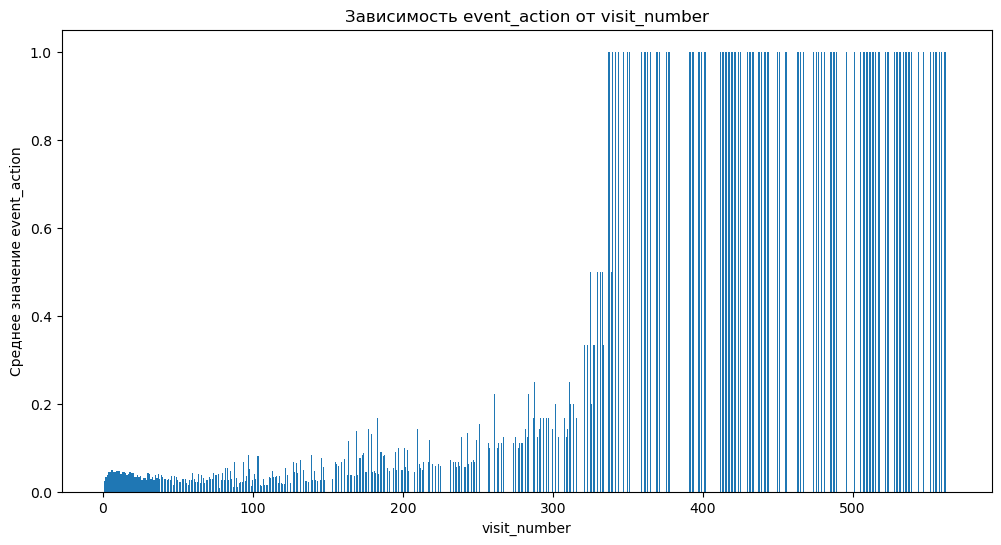

In [63]:
grouped_data = df_clean.groupby('visit_number')['event_action'].mean()

plt.figure(figsize=(12, 6))
plt.bar(grouped_data.index, grouped_data.values)
plt.xlabel('visit_number')
plt.ylabel('Среднее значение event_action')
plt.title('Зависимость event_action от visit_number')
plt.show()

### Feature engineering

In [66]:
df_eng = df_clean.copy()

In [67]:
df_eng.describe(include='all')

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action
count,1860042,1860042,1860042,1860042,1.860042e+06,1860042,1860042,1860042,1860042,1860042,1860042,1860042,1860042,1860042,1860042,1860042,1.860042e+06
unique,1860042,1391719,226,85318,NaN,294,55,413,287,3,13,206,5039,57,166,2548,NaN
top,9055434745589932991.1637753792.1637753792,1750498477.1629450062,2021-05-24,12:00:00,NaN,zpyiodjmcfzvopfshgjl,banner,ltuzkdkfxrgvceowkvyg,jnhcplzpxemwdnriyobf,mobile,android,apple,414x896,chrome,russia,moscow,NaN
freq,1,462,39453,61067,NaN,578290,552272,463481,1006599,1474871,942042,592043,169090,1013436,1800565,805329,NaN
mean,NaN,NaN,NaN,NaN,2.712804e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.704993e-02
std,NaN,NaN,NaN,NaN,1.182907e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.622290e-01
min,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
50%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
75%,NaN,NaN,NaN,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00


##### date

In [68]:
df_eng['visit_date'] = pd.to_datetime(df_eng['visit_date'])

df_eng['month'] = df_eng.visit_date.apply(lambda x: x.month)
df_eng['dayofweek'] = df_eng.visit_date.apply(lambda x: x.day)
df_eng['year'] = df_eng.visit_date.apply(lambda x: x.year)

In [69]:
df_eng.year.value_counts()

2021    1860042
Name: year, dtype: int64

In [70]:
df_eng['visit_time'] = pd.to_datetime(df_eng['visit_time'], format='%H:%M:%S')
df_eng['hour'] = df_eng['visit_time'].dt.hour

In [71]:
df_eng = df_eng.drop(columns = ['year'])

##### session_id & client_id

In [72]:
df_session = df_eng[['session_id', 'event_action', 'client_id']].copy()
df_session['x_parts_session'] = df_session['session_id'].str.split('.')
df_session['x_parts_client'] = df_session['client_id'].str.split('.')

df_session['session_x0'] = df_session['x_parts_session'].str[0]
df_session['session_x1'] = df_session['x_parts_session'].str[1]
df_session['session_x2'] = df_session['x_parts_session'].str[2]

df_session['client_x0'] = df_session['x_parts_client'].str[0]
df_session['client_x1'] = df_session['x_parts_client'].str[1]                    

unique_session_x0_count = df_session['session_x0'].nunique()
unique_session_x1_count = df_session['session_x1'].nunique()
unique_session_x2_count = df_session['session_x2'].nunique()

unique_client_x0_count = df_session['client_x0'].nunique()
unique_client_x1_count = df_session['client_x1'].nunique()

print(f"Количество уникальных значений в session_x0: {unique_session_x0_count}")
print(f"Количество уникальных значений в session_x1: {unique_session_x1_count}")
print(f"Количество уникальных значений в session_x2: {unique_session_x2_count}")

print(f"Количество уникальных значений в client_x0: {unique_client_x0_count}")
print(f"Количество уникальных значений в client_x1: {unique_client_x1_count}")


Количество уникальных значений в session_x0: 1391719
Количество уникальных значений в session_x1: 1707959
Количество уникальных значений в session_x2: 1710523
Количество уникальных значений в client_x0: 1391309
Количество уникальных значений в client_x1: 1295741


##### device_screen_resolution len

In [73]:
df_eng['dev_scr_res_len'] = df_eng.apply (lambda x: len(x.device_screen_resolution), axis = 1)
df_eng.dev_scr_res_len.value_counts()

7     1477800
9      201863
8      180339
10         29
3          11
Name: dev_scr_res_len, dtype: int64

##### browser

In [74]:
def clean_device_browser(browser):
    if 'instagram' in browser:
        return 'instagram'
    elif 'android' in browser:
        return 'android webview'
    elif 'opera' in browser:
        return 'opera'
    elif 'mozilla' in browser:
        return 'mozilla'
    elif 'internet explorer' in browser:
        return 'edge'
    else:
        return browser

df_eng['device_browser'] = df_eng['device_browser'].apply(clean_device_browser)
df_eng.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,...,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action,month,dayofweek,hour,dev_scr_res_len
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,1900-01-01 14:36:32,1,zpyiodjmcfzvopfshgjl,banner,leophuyfvzonfnzggfcd,vcipmpagbniqhyynkxqp,mobile,...,huawei,360x720,chrome,russia,zlatoust,0,11,24,14,7
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,1900-01-01 08:21:30,1,mvfhsxitijurizxsqzqt,cpm,ftjnldytrxawygzymfkv,xhoenqgdqsgfepynpwko,mobile,...,samsung,385x854,samsung internet,russia,moscow,0,11,14,8,7
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,1900-01-01 02:42:06,1,zpyiodjmcfzvopfshgjl,banner,leophuyfvzonfnzggfcd,vcipmpagbniqhyynkxqp,mobile,...,huawei,360x720,chrome,russia,krasnoyarsk,0,12,28,2,7
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,1900-01-01 05:00:00,1,kjslglqlzykirbcdigcd,cpc,other,nobklgtuvqywkxqheywm,mobile,...,xiaomi,393x786,chrome,russia,moscow,0,5,29,5,7
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,1900-01-01 05:00:00,2,kjslglqlzykirbcdigcd,cpc,other,other,mobile,...,xiaomi,393x786,chrome,russia,moscow,0,5,29,5,7


##### utm_source & utm_adcontent & utm_campaign & utm_medium & device_browser & device_os & device_brand

In [75]:
columns_to_filter = ['utm_source', 'utm_medium', 'utm_adcontent', 'utm_campaign',
                         'device_browser', 'device_os', 'device_brand']

for column in columns_to_filter:
    print(df_eng[column].value_counts())

zpyiodjmcfzvopfshgjl    578290
fdllacsmythwscvmvqvl    300575
kjslglqlzykirbcdigcd    266354
mvfhsxitijurizxsqzqt    186199
bhcvlfoacwvwtykyqhve    116320
                         ...  
gykgjdhsxirufphfiyse         1
wrhphorkhkxaenrclbfo         1
tjkugsegmhklezdcqbrx         1
wpmatvduimutnvmnvpjo         1
bellrslnbzqzaixvfgxj         1
Name: utm_source, Length: 294, dtype: int64
banner               552272
cpc                  434794
(none)               300575
cpm                  242123
referral             152050
organic               63034
email                 29240
push                  28035
stories               10582
cpv                    8022
blogger_channel        8015
smartbanner            6794
blogger_stories        4312
cpa                    4279
tg                     4011
app                    2836
post                   2326
smm                    1985
outlook                1332
clicks                  934
blogger_header          771
(not set)               480

In [76]:
for column in columns_to_filter:
    counts = df_eng[column].value_counts()
    filt = counts[counts < 750].index
    df_eng[column] = df_eng[column].apply(lambda x: 'rare' if x in filt else x)

In [ ]:
for column in columns_to_filter:
    print(df_eng[column].value_counts())

##### geo_city

In [77]:
df_eng['is_russia'] = df_eng['geo_country'].apply(lambda x: 1 if x == 'russia' else 0)

In [78]:
df_eng['is_available'] = df_eng['geo_city'].apply(lambda x: 1 if x == 'moscow' or x == 'saint petersburg' else 0)

In [79]:
df_eng['geo_country'] = df_eng['geo_country'].apply(lambda x: 'россия' if x == 'russia' else x)

In [80]:
cities = {
    'tuymazy': 'туймазы',
    'zagorjanskas': 'загорянский',
    'novoye devyatkino': 'новое девяткино',
    'yablonovsky': 'яблоновский',
    'petrovo-dalneye': 'петрово-дальнее',
    'kalininets': 'калининец'
}

df_eng['geo_city'] = df_eng['geo_city'].replace(cities)

In [81]:
df_eng[(df_eng['geo_city'] == '(not set)') & (df_eng['geo_country'] == '(not set)')].event_action.value_counts()

0    1117
1      29
Name: event_action, dtype: int64

In [82]:
df_eng = df_eng[(df_eng['geo_city'] != '(not set)') & (df_eng['geo_country'] != '(not set)')]

In [83]:
def geocode_cities(df):
    from geopy.geocoders import Nominatim
    
    df_copy = df.copy()

    geolocator = Nominatim(user_agent="geo_app")
    try:
        with open('data/coords_cache.pkl', 'rb') as cache_file:
            coords_cache = pickle.load(cache_file)
    except (FileNotFoundError, EOFError):
        coords_cache = {}

    def get_coordinates(city, coord_type):
        if city not in coords_cache:
            try:
                if city == '(not set)' or city is None:
                    coords_cache[city] = None
                else:
                    location = geolocator.geocode(city)
                    if location:
                        coords_cache[city] = {
                            'latitude': location.latitude,
                            'longitude': location.longitude
                        }
                    else:
                        coords_cache[city] = None
                with open('data/coords_cache.pkl', 'wb') as cache_file:
                    pickle.dump(coords_cache, cache_file)
            except Exception as e:
                print(f"Error geocoding {city}: {str(e)}")
                coords_cache[city] = None

        if coords_cache[city]:
            return coords_cache[city][coord_type]
        else:
            return None

    df_copy['latitude'] = df_copy['geo_city'].apply(lambda x: get_coordinates(x, 'latitude'))
    df_copy['longitude'] = df_copy['geo_city'].apply(lambda x: get_coordinates(x, 'longitude'))

    df_copy['latitude'].fillna(df_copy['geo_country'].apply(
        lambda x: get_coordinates(x, 'latitude')), inplace=True)
    df_copy['longitude'].fillna(df_copy['geo_country'].apply(
        lambda x: get_coordinates(x, 'longitude')), inplace=True)

    return df_copy


df_eng = geocode_cities(df_eng)
df_eng.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,...,geo_city,event_action,month,dayofweek,hour,dev_scr_res_len,is_russia,is_available,latitude,longitude
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,1900-01-01 14:36:32,1,zpyiodjmcfzvopfshgjl,banner,leophuyfvzonfnzggfcd,vcipmpagbniqhyynkxqp,mobile,...,zlatoust,0,11,24,14,7,1,0,55.034639,59.529269
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,1900-01-01 08:21:30,1,mvfhsxitijurizxsqzqt,cpm,ftjnldytrxawygzymfkv,xhoenqgdqsgfepynpwko,mobile,...,moscow,0,11,14,8,7,1,1,55.625578,37.606392
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,1900-01-01 02:42:06,1,zpyiodjmcfzvopfshgjl,banner,leophuyfvzonfnzggfcd,vcipmpagbniqhyynkxqp,mobile,...,krasnoyarsk,0,12,28,2,7,1,0,56.009097,92.872515
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,1900-01-01 05:00:00,1,kjslglqlzykirbcdigcd,cpc,other,rare,mobile,...,moscow,0,5,29,5,7,1,1,55.625578,37.606392
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,1900-01-01 05:00:00,2,kjslglqlzykirbcdigcd,cpc,other,other,mobile,...,moscow,0,5,29,5,7,1,1,55.625578,37.606392


In [84]:
grouped = df_eng.groupby('geo_country')
filtered = grouped.filter(lambda x: (x['event_action'] == 0).all())
countries = filtered['geo_country'].unique()
countries

array(['ireland', 'singapore', 'portugal', 'mexico', 'uganda',
       'bosnia & herzegovina', 'lebanon', 'sudan', 'cambodia', 'vietnam',
       'mongolia', 'mauritius', 'central african republic',
       'congo - kinshasa', 'burundi', 'chile', 'qatar', 'malaysia',
       'luxembourg', 'bangladesh', 'japan', 'togo', 'venezuela',
       'sri lanka', 'angola', 'guinea', 'kenya', 'senegal', 'libya',
       'tanzania', 'nicaragua', 'ethiopia', 'syria', 'myanmar (burma)',
       'yemen', 'côte d’ivoire', 'colombia', 'laos', 'algeria', 'rwanda',
       'bahrain', 'guatemala', 'mozambique', 'new zealand', 'zimbabwe',
       'ghana', 'namibia', 'malawi', 'new caledonia', 'gibraltar',
       'taiwan', 'andorra', 'paraguay', 'mali', 'barbados', 'réunion',
       'haiti', 'somalia', 'panama', 'sierra leone', 'zambia', 'uruguay',
       'chad', 'peru', 'nepal', 'fiji', 'faroe islands', 'costa rica',
       'ecuador', 'french guiana', 'burkina faso', 'cameroon', 'honduras',
       'kuwait', 'niger',

#### StandardScaler

In [86]:
quantitative_variables = ['visit_number', 'month', 'dayofweek', 'hour', 'dev_scr_res_len', 
                          'latitude', 'longitude']

data = df_eng[quantitative_variables].copy()
data

,visit_number,month,dayofweek,hour,dev_scr_res_len,latitude,longitude
0,1,11,24,14,7,55.034639,59.529269
1,1,11,14,8,7,55.625578,37.606392
2,1,12,28,2,7,56.009097,92.872515
3,1,5,29,5,7,55.625578,37.606392
4,2,5,29,5,7,55.625578,37.606392
...,...,...,...,...,...,...,...
1860037,1,12,22,10,9,55.625578,37.606392
1860038,1,5,26,8,7,44.863258,43.440691
1860039,1,11,15,15,7,55.625578,37.606392
1860040,1,11,29,15,7,55.159841,61.402555


In [87]:
std_scaler = StandardScaler()
std_scaler.fit(data)
std_scaled = std_scaler.transform(data)
print(std_scaled)
print(std_scaled.shape)

[[-1.45288800e-01  7.51018190e-01  7.98403573e-01 ... -4.63989750e-01
  -2.59437263e-02  9.29144810e-01]
 [-1.45288800e-01  7.51018190e-01 -3.37977046e-01 ... -4.63989750e-01
   8.97953155e-02 -1.09493471e-01]
 [-1.45288800e-01  1.20525583e+00  1.25295582e+00 ... -4.63989750e-01
   1.64909891e-01  2.50884485e+00]
 ...
 [-1.45288800e-01  7.51018190e-01 -2.24338984e-01 ... -4.63989750e-01
   8.97953155e-02 -1.09493471e-01]
 [-1.45288800e-01  7.51018190e-01  1.36659388e+00 ... -4.63989750e-01
  -1.42225230e-03  1.01789528e+00]
 [-1.45288800e-01  1.20525583e+00  1.59387001e+00 ...  1.08981648e+00
   8.97953155e-02 -1.09493471e-01]]
(1781870, 7)


In [88]:
df_eng[std_scaler.get_feature_names_out()+'_std'] = std_scaled

df_eng.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,...,is_available,latitude,longitude,visit_number_std,month_std,dayofweek_std,hour_std,dev_scr_res_len_std,latitude_std,longitude_std
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,1900-01-01 14:36:32,1,zpyiodjmcfzvopfshgjl,banner,leophuyfvzonfnzggfcd,vcipmpagbniqhyynkxqp,mobile,...,0,55.034639,59.529269,-0.145289,0.751018,0.798404,0.058554,-0.46399,-0.025944,0.929145
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,1900-01-01 08:21:30,1,mvfhsxitijurizxsqzqt,cpm,ftjnldytrxawygzymfkv,xhoenqgdqsgfepynpwko,mobile,...,1,55.625578,37.606392,-0.145289,0.751018,-0.337977,-0.924933,-0.46399,0.089795,-0.109493
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,1900-01-01 02:42:06,1,zpyiodjmcfzvopfshgjl,banner,leophuyfvzonfnzggfcd,vcipmpagbniqhyynkxqp,mobile,...,0,56.009097,92.872515,-0.145289,1.205256,1.252956,-1.908421,-0.46399,0.164910,2.508845
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,1900-01-01 05:00:00,1,kjslglqlzykirbcdigcd,cpc,other,rare,mobile,...,1,55.625578,37.606392,-0.145289,-1.974408,1.366594,-1.416677,-0.46399,0.089795,-0.109493
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,1900-01-01 05:00:00,2,kjslglqlzykirbcdigcd,cpc,other,other,mobile,...,1,55.625578,37.606392,-0.062243,-1.974408,1.366594,-1.416677,-0.46399,0.089795,-0.109493


#### OneHotEncoder

In [ ]:
categories = ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'device_category', 'device_brand', 'device_browser', 'device_os']

data = df_eng[categories].copy()
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(data)
ohe_data = ohe.transform(data)
df_eng[ohe.get_feature_names_out()] = ohe_data

In [90]:
df_eng.shape

(1781870, 271)

#### drop

In [91]:
df_drop = df_eng.copy()

In [92]:
columns_for_drop = ['session_id', 'client_id', 'visit_date', 'visit_time', 'visit_number',
       'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'device_category', 'device_brand', 'device_screen_resolution',
       'device_browser', 'geo_country', 'geo_city', 'month',
       'dayofweek', 'hour', 'dev_scr_res_len', 'latitude',
       'longitude', 'device_os']

df_drop = df_drop.drop(columns_for_drop, axis=1)

In [93]:
df_drop.head()

,event_action,is_russia,is_available,visit_number_std,month_std,dayofweek_std,hour_std,dev_scr_res_len_std,latitude_std,longitude_std,...,device_browser_safari (in-app),device_browser_samsung internet,device_browser_uc browser,device_browser_yabrowser,device_os_android,device_os_ios,device_os_linux,device_os_macintosh,device_os_rare,device_os_windows
0,0,1,0,-0.145289,0.751018,0.798404,0.058554,-0.46399,-0.025944,0.929145,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,1,1,-0.145289,0.751018,-0.337977,-0.924933,-0.46399,0.089795,-0.109493,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,-0.145289,1.205256,1.252956,-1.908421,-0.46399,0.164910,2.508845,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,1,1,-0.145289,-1.974408,1.366594,-1.416677,-0.46399,0.089795,-0.109493,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,1,1,-0.062243,-1.974408,1.366594,-1.416677,-0.46399,0.089795,-0.109493,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_drop.to_csv('data/df_drop.csv', index=False)

## Modeling